# Age Estimation and Gender Classification

Train CNN models to estimate a person's age and predict their gender based on face images.

Two CNN models.
- Model A: Train a CNN model from scratch
- Model B: Fine-tune a pre-trained model to perform the same task

**Dataset**

Contains 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset.

**Performance Metric**

- age estimation: - Mean Absolute Error (MAE)
- gender prediction: accuracy

## Setting Up: Mount the google drive and enable GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualize a few photos - gain initial insights into the dataset
It's always beneficial to thoroughly understand the data before beginning the training process. To get a first-hand impression of the dataset - 20 images, along with their corresponding age and gender labels.

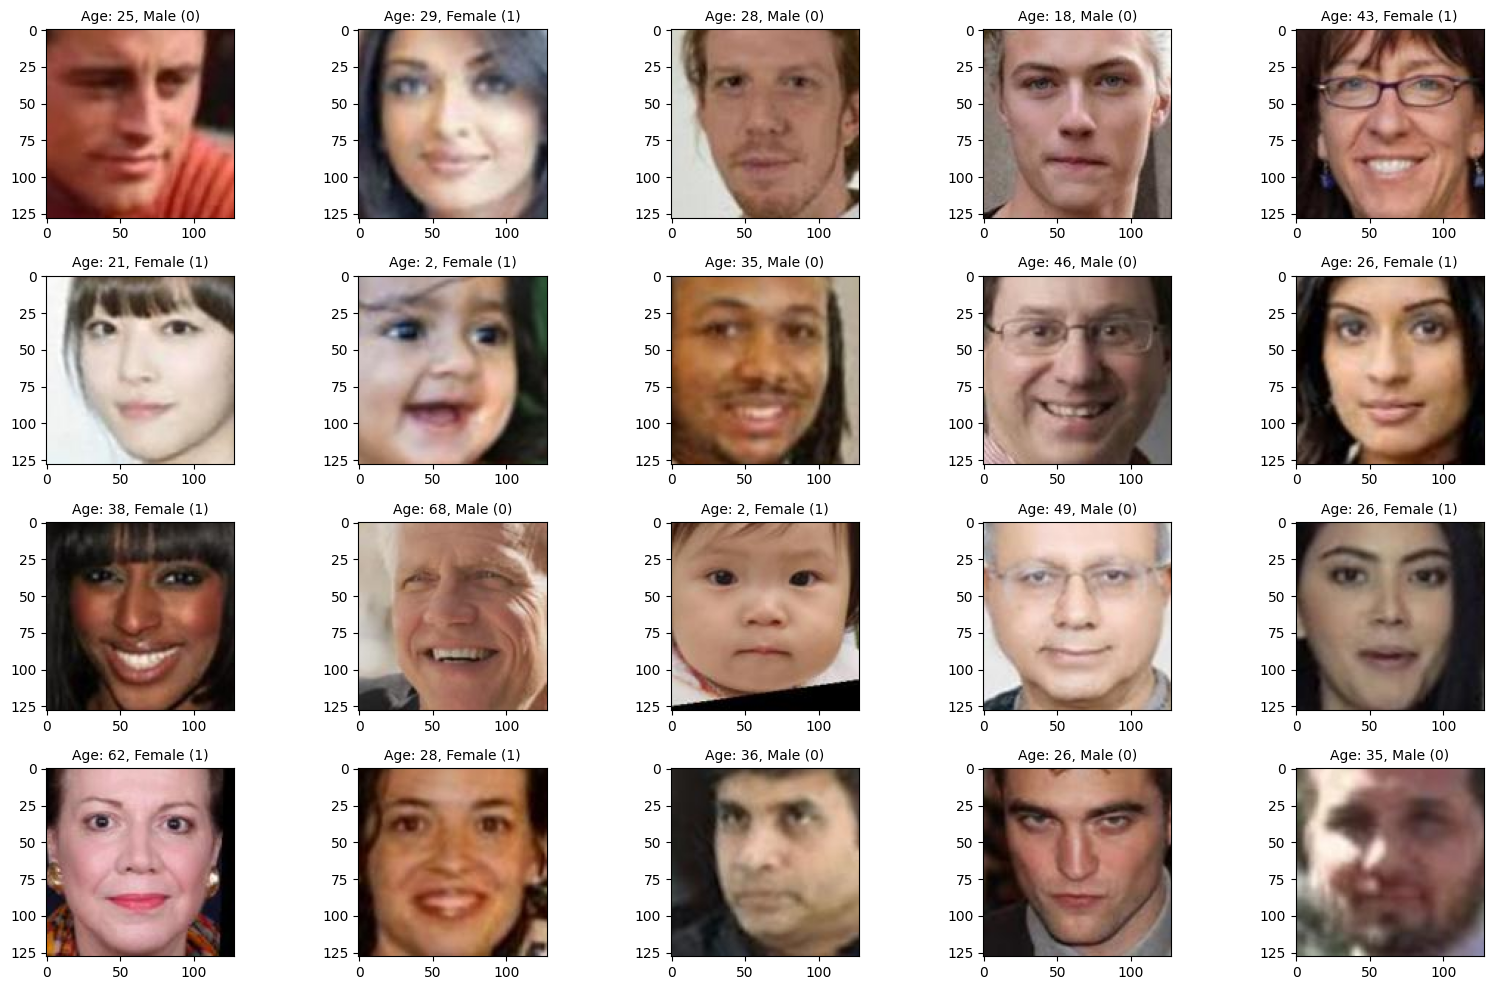

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import cv2

f_name ="/content/drive/MyDrive/Colab Notebooks/train_val"
images = [f for f in os.listdir(f_name) if f.endswith('.jpg')]
random_images = random.sample(images, min(20, len(images)))


plt.figure(figsize=(16, 10))

for i in range(1, len(random_images) + 1):
    image_path = f"{f_name}/{random_images[i - 1]}"
    image = Image.open(image_path)

    plt.subplot(4, 5, i)

    parts = random_images[i-1].split("_")
    age = parts[0]
    gender = "Male (0)" if parts[1] == "0" else "Female (1)"
    plt.title(f"Age: {age}, {gender}", fontsize=10)
    plt.imshow(image, cmap='gray_r')
    # plt.axis('off')

plt.tight_layout()
plt.show()

## Data Pre-Processing
1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation

Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...


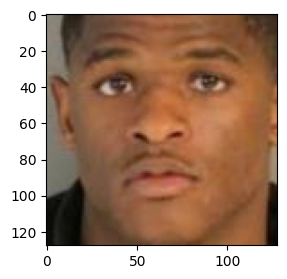

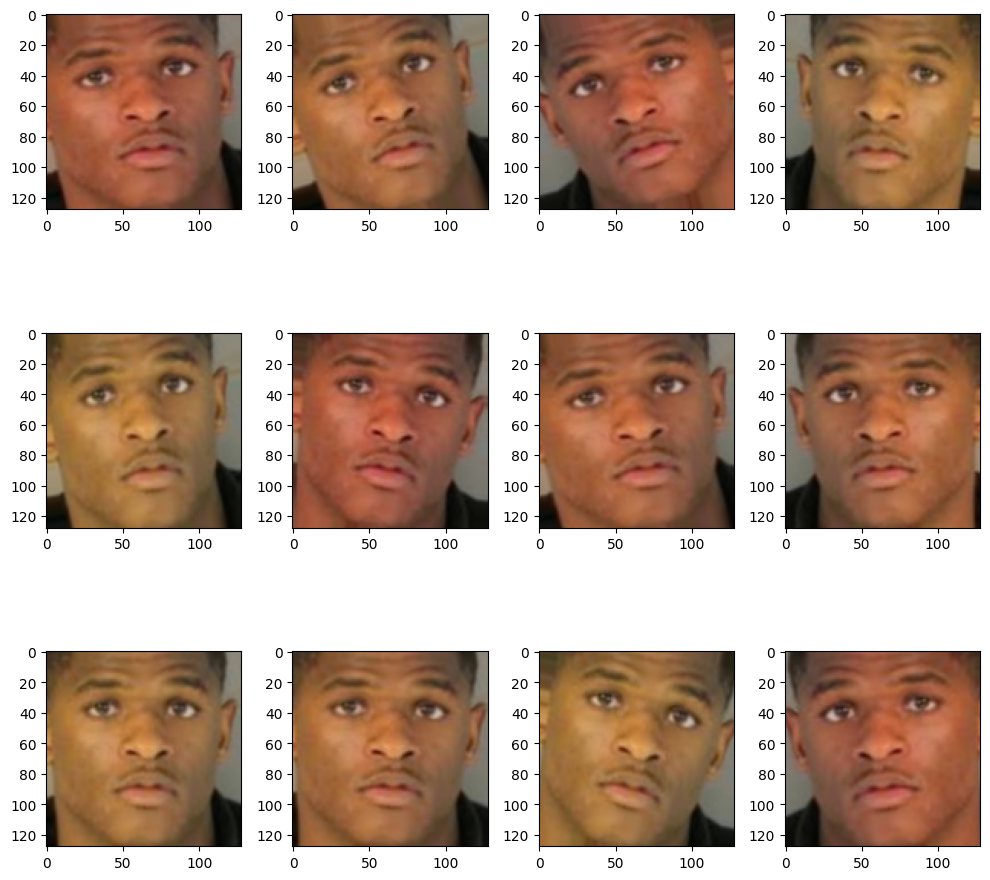

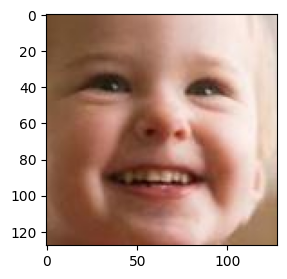

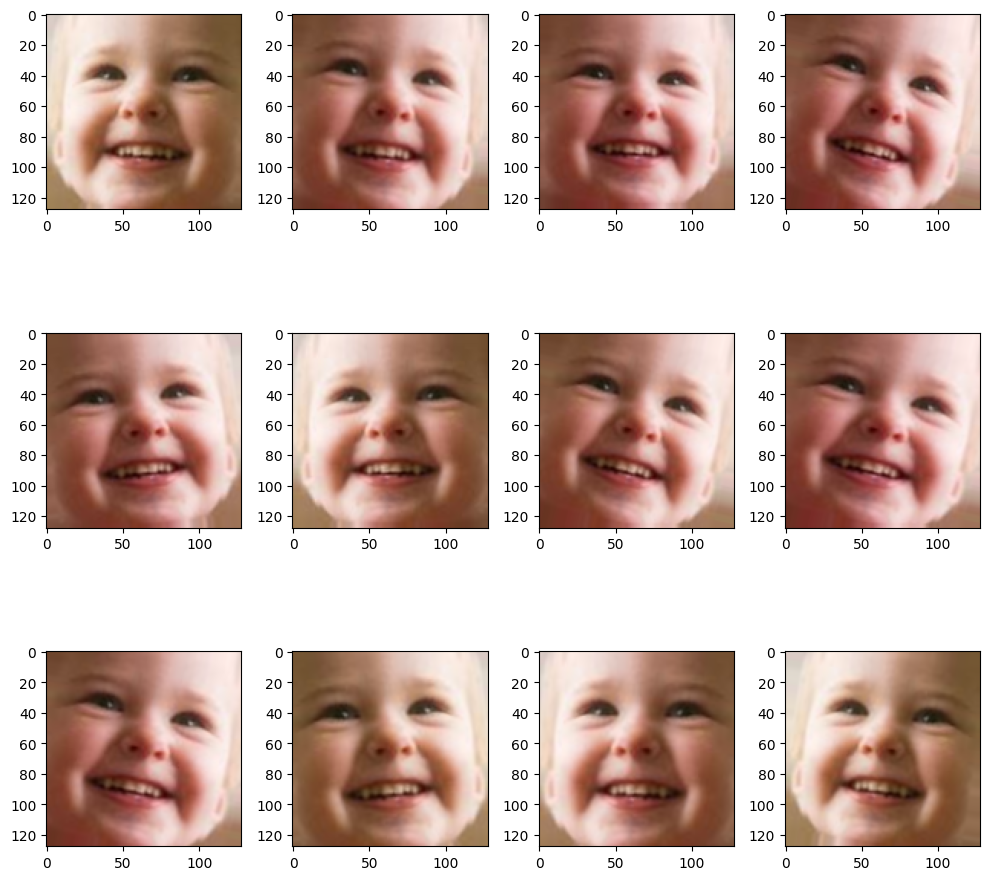

In [3]:
import os
import random
import numpy as np

folder_train_val = "/content/drive/MyDrive/Colab Notebooks/train_val"
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name))
    img = img / 255.0  # Normalize pixel values
    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

#
######### code for data augmentation #########
#
from tensorflow.keras import layers, Sequential
import tensorflow as tf

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05, fill_mode='nearest'),
    layers.RandomZoom(-0.05, 0.05, fill_mode='nearest'),
    # layers.RandomTranslation(0.02, fill_mode = "nearest"),
    layers.RandomContrast(0.01),
    layers.RandomHue(0.05),
    # layers.RandomBrightness(0.001),
])
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_age))

be_show_augment = True

if be_show_augment:
    for images, labels in train_ds.batch(2).take(2):  # one batch of images
        plt.figure(figsize=(3, 3))
        img = images[0]
        plt.imshow(img[..., ::-1])
        # plt.axis("off")
        plt.show()

        plt.figure(figsize=(10, 10))
        img = tf.expand_dims(img, axis=0)  # batch dimension

        for i in range(12):
            augmented_image = data_augmentation(img, training=True)
            plt.subplot(3, 4, i + 1)
            plt.imshow(augmented_image[0, ..., ::-1])  # Remove batch dim
            # plt.axis("off")
        plt.tight_layout()
        plt.show()

## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_185CLONE     │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 126, 126, 32)   │            896 │ keras_tensor_185CLONE… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 63, 63, 32)     │              0 │ conv2d_16[1][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_16[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 30, 30, 64)     │              0 │ conv2d_17[1][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 30, 30, 64)     │              0 │ max_pooling2d_17[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ dropout_32[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 14, 14, 128)    │              0 │ conv2d_18[1][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 14, 14, 128)    │              0 │ max_pooling2d_18[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 12, 12, 256)    │        295,168 │ dropout_33[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 6, 6, 256)      │              0 │ conv2d_19[1][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 6, 6, 256)      │              0 │ max_pooling2d_19[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 9216)           │              0 │ dropout_34[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │      1,179,776 │ flatten_4[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 128)            │              0 │ dense_16[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 128)            │              0 │ dropout_35[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 64)             │          8,256 │ dropout_36[1][0]       │
├──────────────────────

 Total params: 1,576,642 (6.01 MB)

 Trainable params: 1,576,642 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

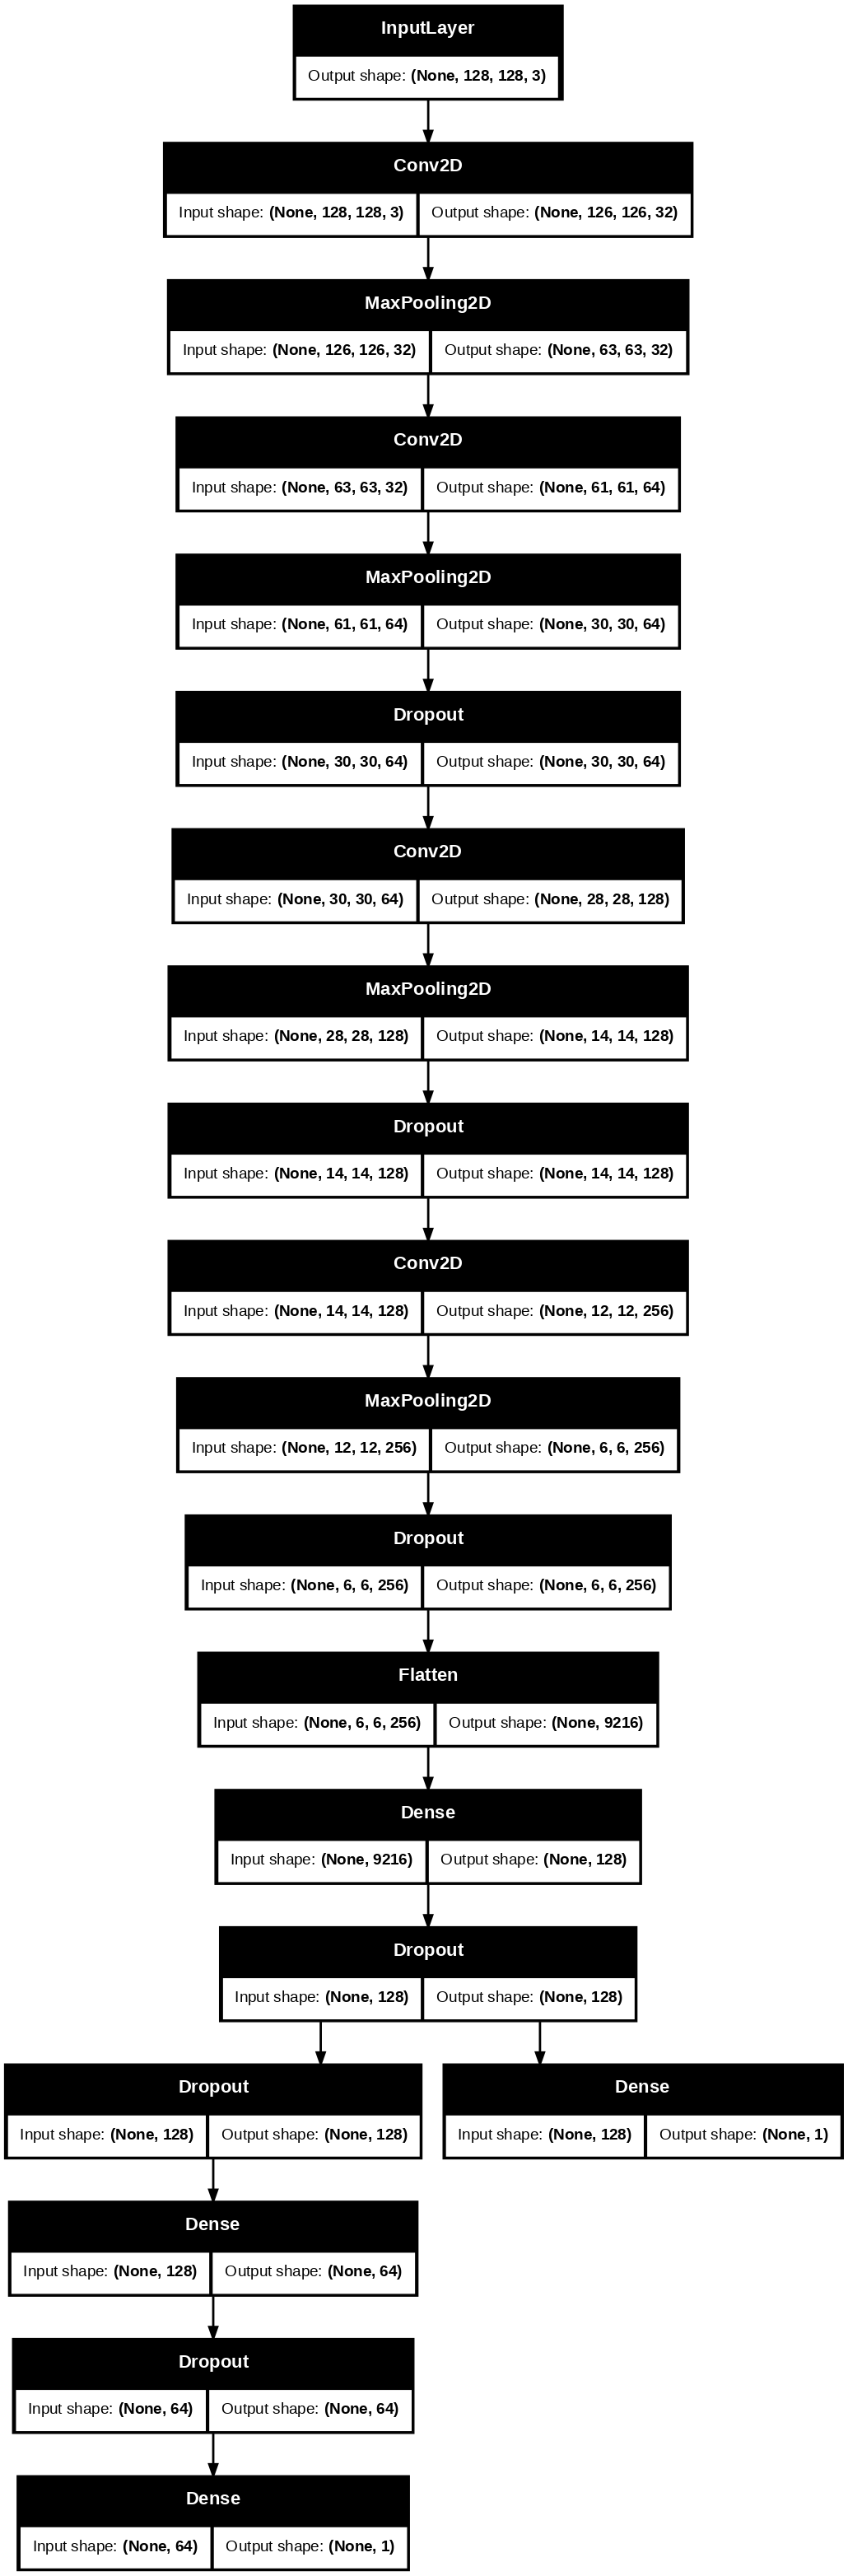

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

input_layer = data_augmentation(Input(shape=(128, 128, 3)))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
# gender = BatchNormalization()(gender)

x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# x = Flatten()(x)
x = Flatten()(x)

# x2 = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)

age = Dropout(0.4)(x)
age = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(age)
age = Dropout(0.3)(age)

# branches
gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(1, activation='relu', name='age')(age)


modelA = Model(inputs=input_layer, outputs=[age_output, gender_output])
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True,dpi=100)

## Compile and train model

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)


modelA.compile(
        optimizer="adam",
        loss={"age": "mae", "gender": "binary_crossentropy"},
        metrics={"age": "mae", "gender": "accuracy"}
    )

historyA = modelA.fit(
    train_images, {"age": train_age, "gender": train_gender},
    validation_data=(val_images, {"age": val_age, "gender": val_gender}),
    epochs=170,
    batch_size= 64,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

folder_models = "/content/drive/MyDrive/models/"
modelA.save(folder_models+'age_gender_A.keras')

Epoch 1/170
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - age_loss: 21.3069 - age_mae: 21.3079 - gender_accuracy: 0.5007 - gender_loss: 1.0383 - loss: 25.3777 - val_age_loss: 21.1241 - val_age_mae: 21.1843 - val_gender_accuracy: 0.6160 - val_gender_loss: 0.6789 - val_loss: 23.8504 - learning_rate: 0.0010
Epoch 2/170
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - age_loss: 16.5199 - age_mae: 16.5201 - gender_accuracy: 0.5330 - gender_loss: 0.8320 - loss: 19.1883 - val_age_loss: 17.3407 - val_age_mae: 17.4018 - val_gender_accuracy: 0.4570 - val_gender_loss: 0.7133 - val_loss: 19.5939 - learning_rate: 0.0010
Epoch 3/170
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - age_loss: 15.9435 - age_mae: 15.9441 - gender_accuracy: 0.5289 - gender_loss: 0.7795 - loss: 18.1213 - val_age_loss: 18.2800 - val_age_mae: 18.3370 - val_gender_accuracy: 0.4570 - val_gender_loss: 0.7136 - val_loss: 20.2385 - learning_rate: 0.0010
Epoch 4/170
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - age_loss: 15.9778 - age_mae: 15.9790 -

## Learning curves
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

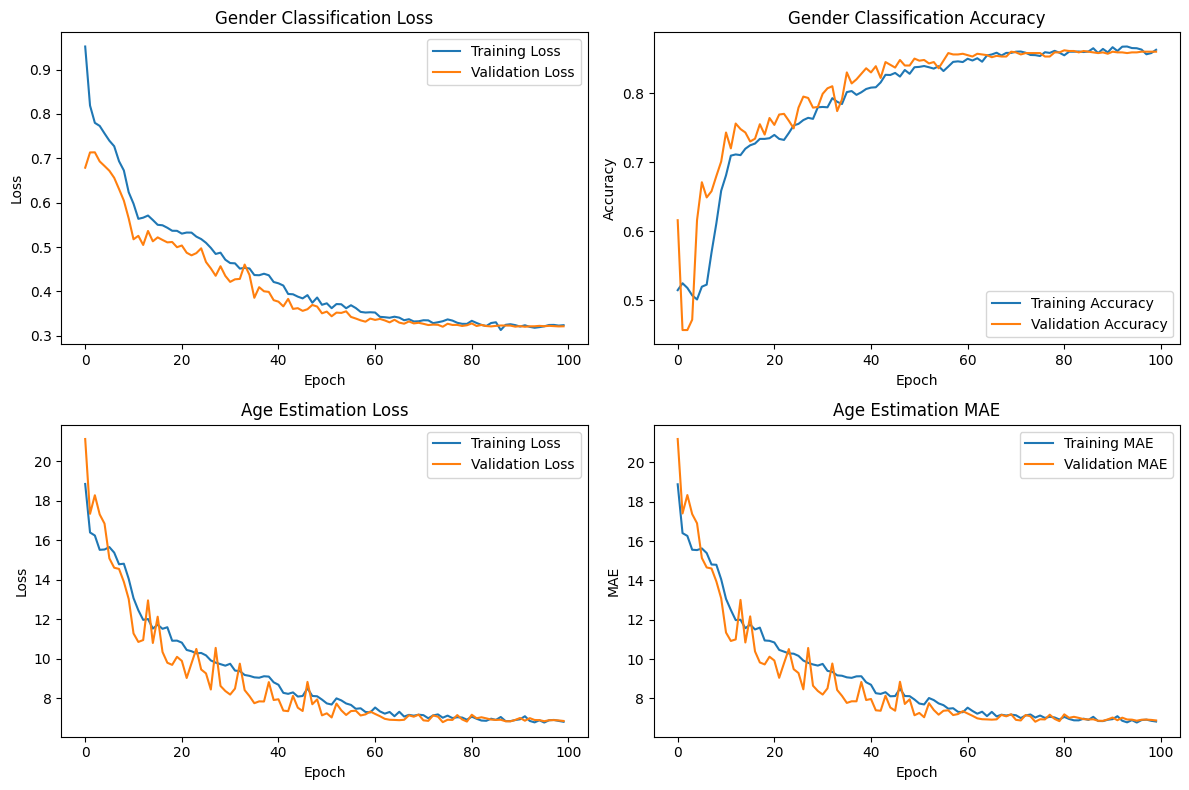

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# gender classification loss
axes[0, 0].plot(historyA.history['gender_loss'], label='Training Loss')
axes[0, 0].plot(historyA.history['val_gender_loss'], label='Validation Loss')
axes[0, 0].set_title('Gender Classification Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# gender classification accuracy
axes[0, 1].plot(historyA.history['gender_accuracy'], label='Training Accuracy')
axes[0, 1].plot(historyA.history['val_gender_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Gender Classification Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# age estimation loss
axes[1, 0].plot(historyA.history['age_loss'], label='Training Loss')
axes[1, 0].plot(historyA.history['val_age_loss'], label='Validation Loss')
axes[1, 0].set_title('Age Estimation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# age estimation MAE
axes[1, 1].plot(historyA.history['age_mae'], label='Training MAE')
axes[1, 1].plot(historyA.history['val_age_mae'], label='Validation MAE')
axes[1, 1].set_title('Age Estimation MAE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## CNN network based on a pre-trained model
pre-trained VGG16 architecture and fine-tune it on this dataset.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         32,896 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            129 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │             65 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,920,258 (56.92 MB)

 Trainable params: 14,364,930 (54.80 MB)

 Non-trainable params: 555,328 (2.12 MB)

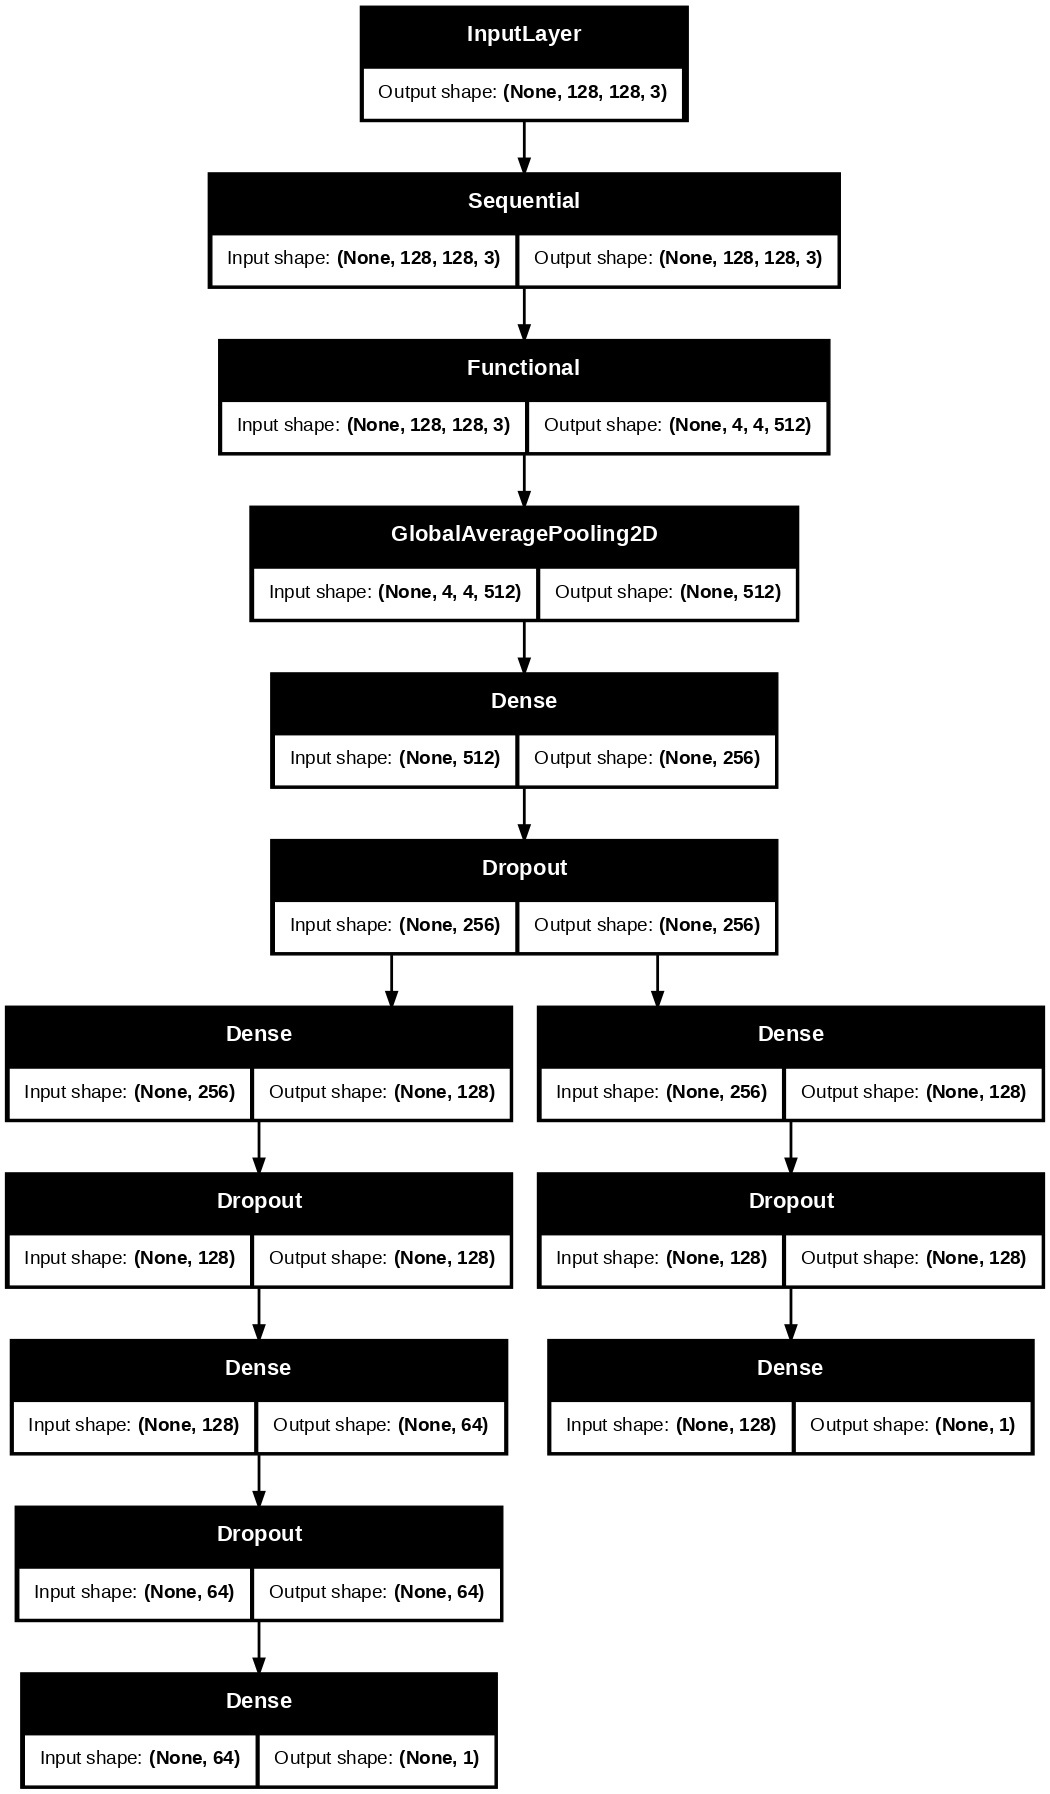

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze layers
for layer in base_model.layers[:8]:
    layer.trainable = False

inputs = Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

# through VGG16 base-feature extraction
x = base_model(x)

# reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)

gender_branch = layers.Dense(128, activation='relu')(x)
gender_branch = layers.Dropout(0.3)(gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(gender_branch)

age_branch = layers.Dense(128, activation='relu')(x)
age_branch = layers.Dropout(0.4)(age_branch)
age_branch = layers.Dense(64, activation='relu')(age_branch)
age_branch = layers.Dropout(0.2)(age_branch)
age_output = layers.Dense(1, activation='relu', name='age')(age_branch)

modelB = Model(inputs=inputs, outputs=[gender_output, age_output])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True,dpi=100)

## Compile and train model

In [8]:
modelB.compile(
    loss={'gender': 'binary_crossentropy', 'age': 'mae'},
    optimizer=Adam(learning_rate=0.0001),
    metrics={'gender': 'accuracy', 'age': 'mae'}
)

# Callbacks
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6
# )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

historyB = modelB.fit(
    train_images,
    {'gender': train_gender, 'age': train_age},
    validation_data=(val_images, {'gender': val_gender, 'age': val_age}),
    epochs=60,
    callbacks=[early_stopping],
    batch_size=32
)

folder_models = "/content/drive/MyDrive/models/"
modelB.save(folder_models + "age_gender_B.keras")

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - age_loss: 20.1430 - age_mae: 20.1430 - gender_accuracy: 0.5074 - gender_loss: 2.2196 - loss: 22.3626 - val_age_loss: 12.1985 - val_age_mae: 12.2242 - val_gender_accuracy: 0.4570 - val_gender_loss: 1.0498 - val_loss: 13.2643
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - age_loss: 12.2786 - age_mae: 12.2786 - gender_accuracy: 0.5451 - gender_loss: 1.4181 - loss: 13.6966 - val_age_loss: 10.1323 - val_age_mae: 10.0837 - val_gender_accuracy: 0.6300 - val_gender_loss: 0.6338 - val_loss: 10.7125
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - age_loss: 10.9743 - age_mae: 10.9743 - gender_accuracy: 0.6062 - gender_loss: 1.0100 - loss: 11.9843 - val_age_loss: 11.6425 - val_age_mae: 11.6205 - val_gender_accuracy: 0.6140 - val_gender_loss: 0.7699 - val_loss: 12.3790
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - age_loss: 11.0752 - age_mae: 11.0752 - gender_accuracy: 0.6467 - gender_loss: 0.8540 - loss: 11.9292

## Learning curves
1. The loss of the gender classification over the training and validation set
2. The accuracy of the gender classification over the training and validation set
3. The loss of the age estimation over the training and validation set
4. The MAE of the age estimation over the training and validation set

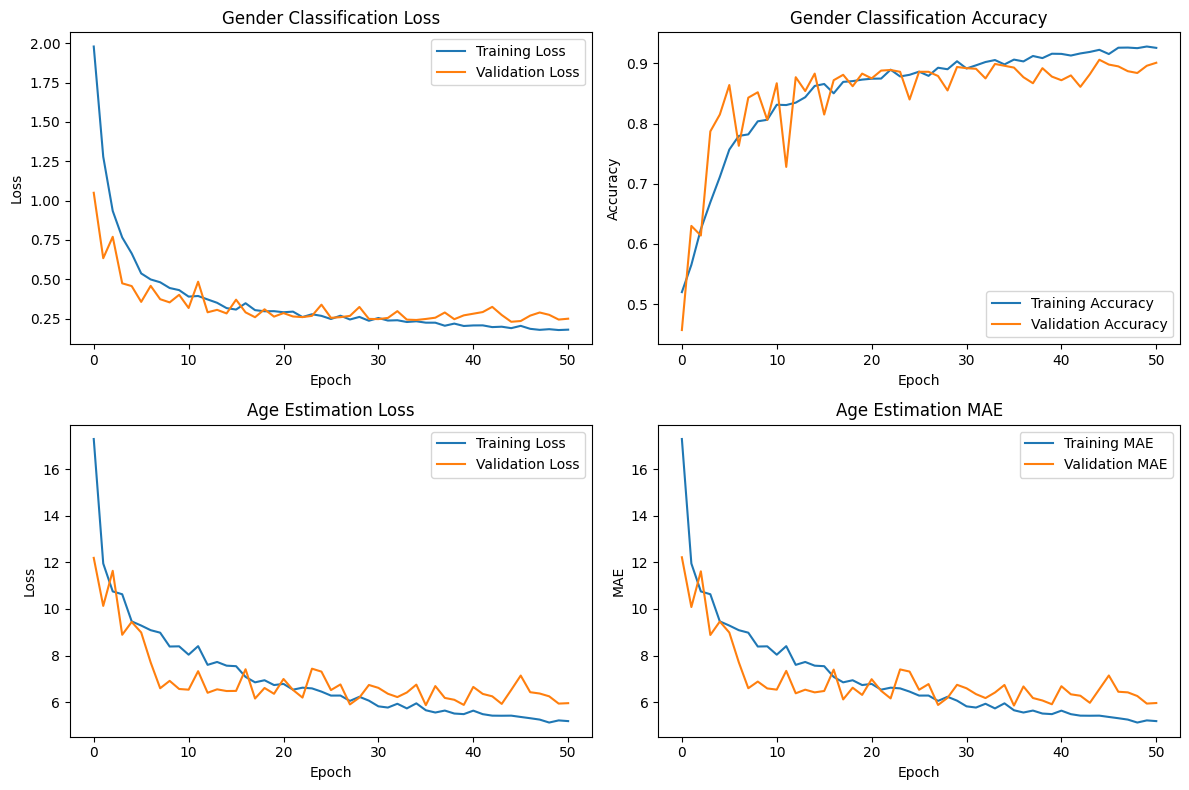

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# gender classification loss
axes[0, 0].plot(historyB.history['gender_loss'], label='Training Loss')
axes[0, 0].plot(historyB.history['val_gender_loss'], label='Validation Loss')
axes[0, 0].set_title('Gender Classification Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# gender classification accuracy
axes[0, 1].plot(historyB.history['gender_accuracy'], label='Training Accuracy')
axes[0, 1].plot(historyB.history['val_gender_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Gender Classification Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# age estimation loss
axes[1, 0].plot(historyB.history['age_loss'], label='Training Loss')
axes[1, 0].plot(historyB.history['val_age_loss'], label='Validation Loss')
axes[1, 0].set_title('Age Estimation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# age estimation MAE
axes[1, 1].plot(historyB.history['age_mae'], label='Training MAE')
axes[1, 1].plot(historyB.history['val_age_mae'], label='Validation MAE')
axes[1, 1].set_title('Age Estimation MAE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()

plt.tight_layout()
plt.show()